In [1]:
#!/usr/bin/env python

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pathlib
import pandas as pd

import infomap

In [2]:
import json

file_path = "../datasets/starwars-full-interactions-allCharacters-merged.json"

with open(file_path) as json_file:
    data = json.load(json_file)
    
metadata = data['nodes']
edges = data['links']

df_metadata = pd.DataFrame(metadata)
df_edges = pd.DataFrame(edges)

df_metadata.reset_index(inplace = True)

df_metadata.rename(columns = {'index' : 'node_id'}, inplace = True)

nodes_list = list(df_metadata.node_id)

edges_list = list(zip(df_edges.source, df_edges.target))

weight = list(df_edges.value)

In [3]:
# initialize a new graph object
G = nx.Graph()

# populate the graph with nodes
G.add_nodes_from(nodes_list)

# populate the graph with edges
G.add_edges_from(edges_list, edge_attr =df_edges.value)

In [4]:
im = infomap.Infomap("--two-level")

for i in range(len(df_edges)):
    im.add_link(df_edges.source[i], df_edges.target[i], df_edges.value[i])

im.run()

print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

communities = im.get_modules()
# if isolated node is observed, add that node the community 'x' which classified that the node has no community
for node in G.nodes:
    if node not in communities.keys():
        communities[node] = 'x'
nx.set_node_attributes(G, communities, 'community')

Found 10 modules with codelength: 4.731914527873392


In [5]:
# +1 from because there are isolated nodes
len(pd.Series(nx.get_node_attributes(G, 'community').values()).unique())

11

In [6]:
pd.Series(nx.get_node_attributes(G, 'community').values()).unique()

array([2, 1, 3, 7, 10, 6, 4, 9, 'x', 5, 8], dtype=object)

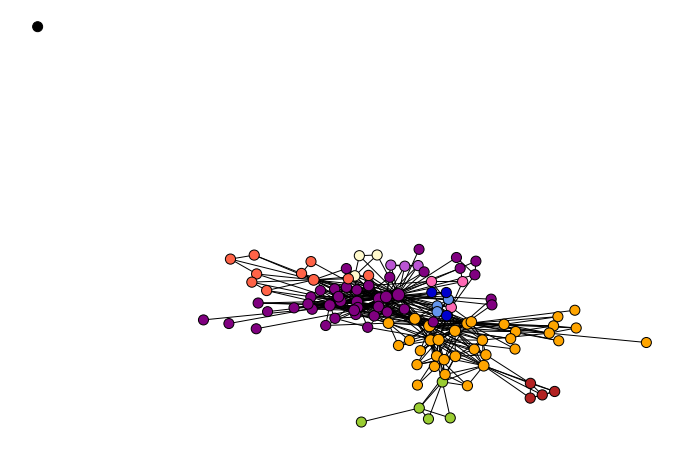

In [7]:
# plot decoration
plt.figure(figsize=(12, 8)) 

# map the color of each node with its community
colors = ['black', 'orange', 'purple', 'tomato', 'cornflowerblue', 'yellowgreen',
      'hotpink', 'lemonchiffon', 'firebrick', 'mediumblue', 'mediumorchid']
color_map = []
# loop over nodes in G
for node in G:
    if communities[node] == 'x':
        color_map.append(colors[0])
    else:
        color_map.append(colors[communities[node]])

# position map
pos = nx.spring_layout(G)

# community index
communities = [c for c in nx.get_node_attributes(G, 'community').values()]
num_communities = len(pd.Series(communities).unique())

# edges
nx.draw_networkx_edges(G, pos)

# nodes
node_collection = nx.draw_networkx_nodes(
G, pos=pos, node_color = color_map, edgecolors= 'black',
node_size = [v+1 * 100 for v in dict(G.degree).values()])

plt.axis('off')
pathlib.Path("output").mkdir(exist_ok=True)
plt.savefig("output/infomap.png")